# Examen 3
# Sofía Hinojosa

In [131]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

In [132]:
data = pd.read_csv("Advertising.csv")
data = data.drop(columns=["Unnamed: 0"])
data

,TV,radio,newspaper,sales
0,230.0999999999999943,37.7999999999999972,69.2000000000000028,22.1000000000000014
1,44.5000000000000000,39.2999999999999972,45.1000000000000014,10.4000000000000004
2,17.1999999999999993,45.8999999999999986,69.2999999999999972,9.3000000000000007
3,151.5000000000000000,41.2999999999999972,58.5000000000000000,18.5000000000000000
4,180.8000000000000114,10.8000000000000007,58.3999999999999986,12.9000000000000004
...,...,...,...,...
195,38.2000000000000028,3.7000000000000002,13.8000000000000007,7.5999999999999996
196,94.2000000000000028,4.9000000000000004,8.0999999999999996,9.6999999999999993
197,177.0000000000000000,9.3000000000000007,6.4000000000000004,12.8000000000000007
198,283.6000000000000227,42.0000000000000000,66.2000000000000028,25.5000000000000000


In [133]:
x = data.drop(columns=["sales"])
y = data["sales"]
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
r2_lineal = r2_score(y, y_pred)
print(f"R^2 score for Linear Regression model: {r2_lineal}")

R^2 score for Linear Regression model: 0.8972106381789522


# 2

In [134]:
model_xgb = xgb.XGBRegressor(random_state=42)
model_xgb.fit(x, y)
y_pred = model_xgb.predict(x)
r2 = r2_score(y, y_pred)
print(f"R^2 XGBoost: {r2}")

R^2 XGBoost: 0.9999997795043769


In [135]:
def objective(trial):   
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-04 17:29:37,721] A new study created in memory with name: no-name-b6ae5992-a986-4d59-bec4-87c9d502e401
[I 2025-12-04 17:29:38,169] Trial 0 finished with value: 0.9999998549330821 and parameters: {'n_estimators': 474, 'max_depth': 5, 'learning_rate': 0.11230357246202277, 'subsample': 0.8969253611236315, 'colsample_bytree': 0.8997848934934687}. Best is trial 0 with value: 0.9999998549330821.
[I 2025-12-04 17:29:38,683] Trial 1 finished with value: 0.9999999000406595 and parameters: {'n_estimators': 389, 'max_depth': 7, 'learning_rate': 0.1694374166739821, 'subsample': 0.7937336813347116, 'colsample_bytree': 0.6390755766218381}. Best is trial 1 with value: 0.9999999000406595.
[I 2025-12-04 17:29:39,056] Trial 2 finished with value: 0.9999961901243962 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.08791892670046428, 'subsample': 0.5593005615403952, 'colsample_bytree': 0.9951423605426188}. Best is trial 1 with value: 0.9999999000406595.
[I 2025-12-04 17:

Best trial:
  Value: 0.9999999894586263
  Params: 
    n_estimators: 319
    max_depth: 9
    learning_rate: 0.2895975214586406
    subsample: 0.5594922974709843
    colsample_bytree: 0.9698710594879874


In [136]:
opt_params = trial.params
model_optimized = xgb.XGBRegressor(**opt_params, random_state=42)
model_optimized.fit(x, y)
y_pred_optimized = model_optimized.predict(x)
r2_optimized = r2_score(y, y_pred_optimized)
print(f"R^2 con hiperparámetros optimizados: {r2_optimized}")

R^2 con hiperparámetros optimizados: 0.9999999894586263


# 3

## Problema 1: No linealidad entre respuesta-factores

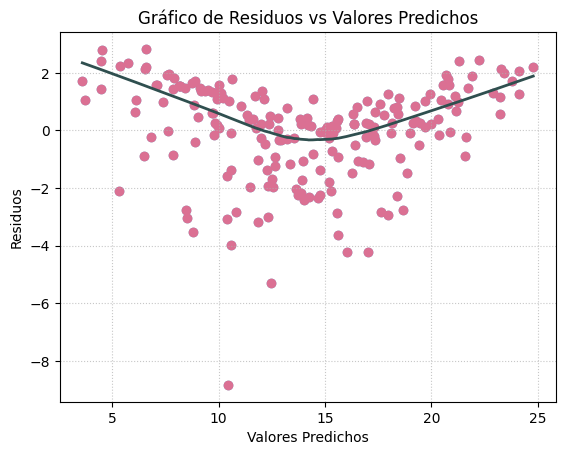

In [137]:
y_pred = model.predict(x)
residuos = y - y_pred
lowess_line = lowess(residuos, y_pred, frac=0.7) 

plt.scatter(y_pred, residuos, alpha=0.6)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='darkslategrey', linewidth=2)

plt.scatter(y_pred, residuos, color = 'palevioletred')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs Valores Predichos')
plt.grid(linestyle=':', alpha=0.7)

Como se puede ver en la gráfica anterior, no hay linealidad entre respuesta y factores. Por esto, voy a aplicar transformación polinomial a las variables.

## Problema 2: Correlación en errores

In [138]:
res = residuos

rho_1 = np.corrcoef(res[:-1], res[1:])[0, 1]
print("Correlación:", rho_1)

Correlación: -0.04709189714421442


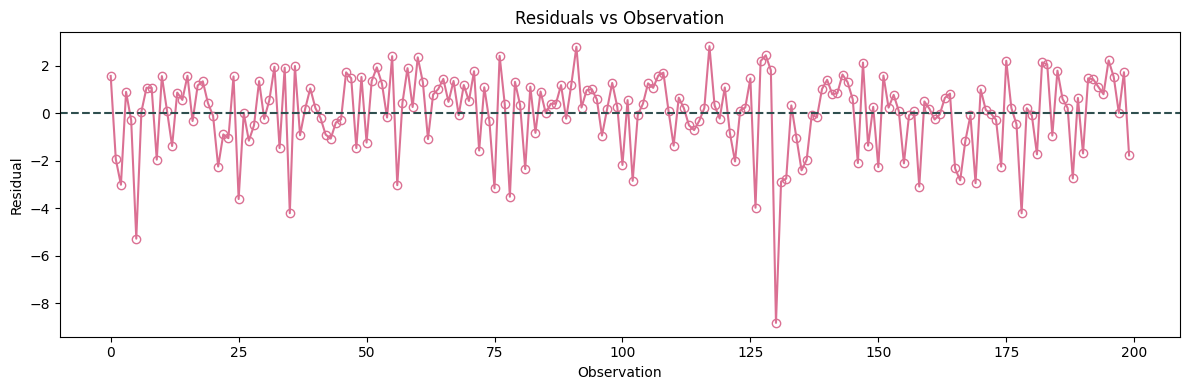

In [139]:
residuos = np.asarray(residuos).reshape(-1)
plt.figure(figsize=(12, 4))
plt.plot(
    residuos,
    marker='o',
    linestyle='-',
    color='palevioletred',
    markerfacecolor='none'
)
plt.axhline(0, linestyle='--', color='darkslategrey')
plt.title("Residuals vs Observation")
plt.xlabel("Observation")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

Como se tuvo una correlación de –0.047 entre los residuos, dado que es muy cercana a cero, no indica correlación significativa.

## Problema 3: Varianza no constante en errores

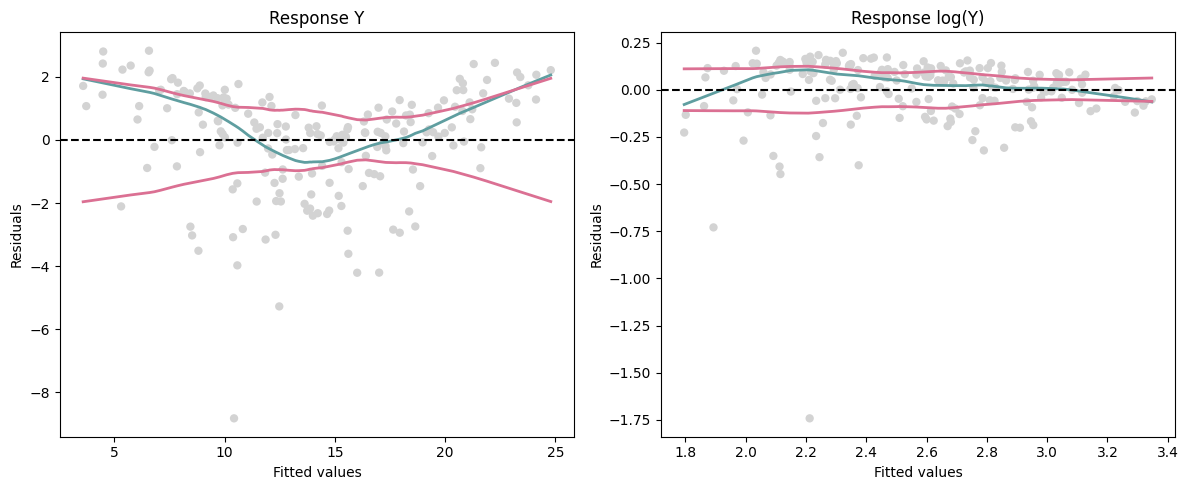

In [140]:
y_pred = y_pred.ravel()

loess_center_y = lowess(residuos, y_pred, frac=0.3, return_sorted=True)
loess_upper_y = lowess(np.abs(residuos), y_pred, frac=0.3, return_sorted=True)
loess_lower_y = loess_upper_y.copy()
loess_lower_y[:,1] = -loess_lower_y[:,1]

logy = np.log(y)
modelo_logy = LinearRegression()
modelo_logy.fit(x, logy)
fitted_logy = modelo_logy.predict(x).ravel()
resid_logy = logy - fitted_logy

loess_center_logy = lowess(resid_logy, fitted_logy, frac=0.3, return_sorted=True)
loess_upper_logy = lowess(np.abs(resid_logy), fitted_logy, frac=0.3, return_sorted=True)
loess_lower_logy = loess_upper_logy.copy()
loess_lower_logy[:,1] = -loess_lower_logy[:,1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuos, color="lightgray", edgecolors="none")
plt.plot(loess_center_y[:,0], loess_center_y[:,1], color="cadetblue", linewidth=2)
plt.plot(loess_upper_y[:,0], loess_upper_y[:,1], color="palevioletred", linewidth=2)
plt.plot(loess_lower_y[:,0], loess_lower_y[:,1], color="palevioletred", linewidth=2)
plt.axhline(0, linestyle="--", color="black")
plt.title("Response Y")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(fitted_logy, resid_logy, color="lightgray", edgecolors="none")
plt.plot(loess_center_logy[:,0], loess_center_logy[:,1], color="cadetblue", linewidth=2)
plt.plot(loess_upper_logy[:,0], loess_upper_logy[:,1], color="palevioletred", linewidth=2)
plt.plot(loess_lower_logy[:,0], loess_lower_logy[:,1], color="palevioletred", linewidth=2)
plt.axhline(0, linestyle="--", color="black")
plt.title("Response log(Y)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

Como se puede notar en la primera gráfica, hay heterocedasticidad. Es decir, la varianza en los errores no es constante, pero aplicando una transformación logaritmica, esto mejora, como se puede ver en el gráfico de la derecha.

##  Problema 4: Outliers

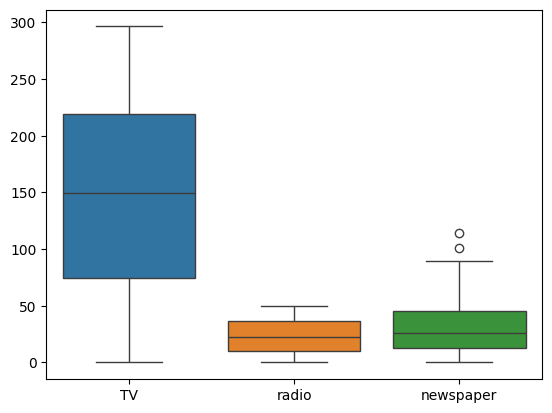

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=x)
plt.show()

En las variables TV y radio no se observan puntos fuera de los bigotes del boxplot, lo que indica que no presentan outliers. En cambio, la variable newspaper muestra dos puntos claramente identificados como outliers, ubicados muy por encima del resto de las observaciones. Estos valores están significativamente alejados de la distribución central, lo que sugiere que algunos gastos en publicidad en periódico son inusualmente altos en comparación con los demás registros del dataset.

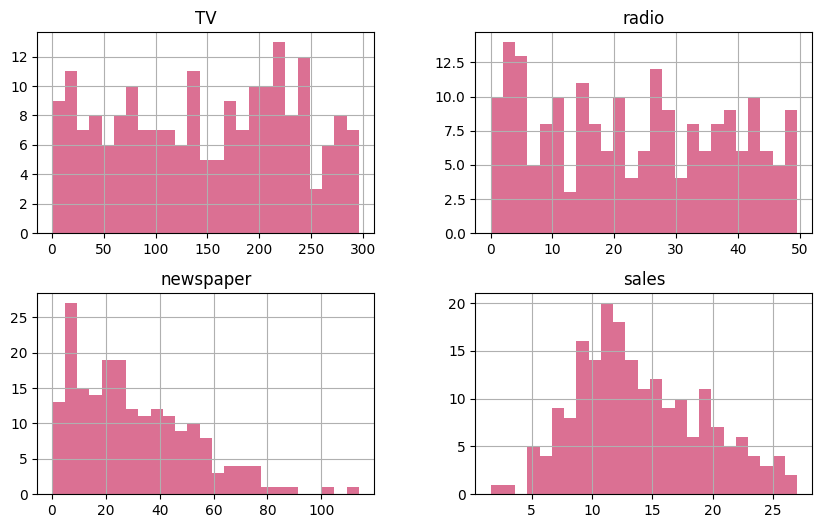

In [142]:
data.hist(figsize=(10,6), color='palevioletred', bins=25)
plt.show()

Sí hay 2 outliers, como se puede ver en el box plot.

## Problema 5: Puntos palanca

In [143]:
X = np.column_stack([np.ones(len(x)), x]) 
H = X @ np.linalg.inv(X.T @ X) @ X.T
h = np.diag(H)

n = X.shape[0]
p = X.shape[1]
umbral = 2 * p / n

puntos_palanca = np.where(h > umbral)[0]

puntos_palanca


array([  5,  16,  36,  75, 101, 128, 165])

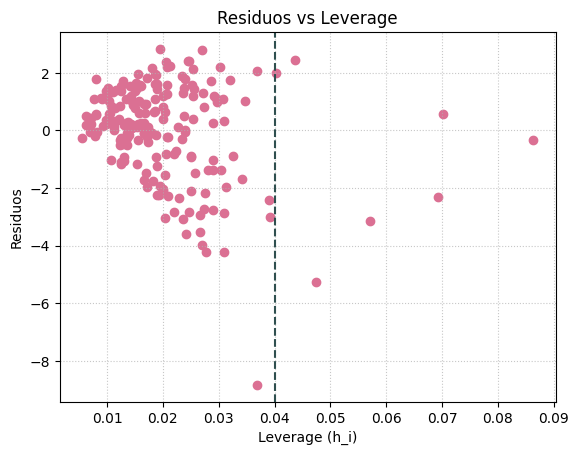

In [144]:
plt.scatter(h, residuos, color='palevioletred')
plt.axvline(umbral, color='darkslategrey', linestyle='--')
plt.xlabel("Leverage (h_i)")
plt.ylabel("Residuos")
plt.title("Residuos vs Leverage")
plt.grid(linestyle=':', alpha=0.7)
plt.show()

Si hay algunos puntos palanca.

## Problema 6: Colinealidad

In [145]:
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,Variable,VIF
0,TV,2.4867718351981929
1,radio,3.2854621001628947
2,newspaper,3.0552445106573844


Los valores de VIF indican que las variables TV, radio y newspaper presentan niveles moderados de colinealidad entre sí. Como todos los factores de inflación de varianza están entre 2.4 y 3.3, muy por debajo del umbral considerado problemático de 5 o 10, no existe evidencia de una colinealidad que afecte la estabilidad o la interpretación del modelo. Esto significa que, aunque las variables comparten algo de información, lo hacen en un grado esperado y no representan un problema para la regresión.

## Corrección de errores

Se hará una transformación polinomial grado 2, se eliminarán los outliers y se agregará penalización.

In [146]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(x)
x_poly_df = pd.DataFrame(x_poly, columns=poly.get_feature_names_out(x.columns))
x_poly_df.head()

,TV,radio,newspaper,TV^2,TV radio,TV newspaper,radio^2,radio newspaper,newspaper^2
0,230.0999999999999943,37.7999999999999972,69.2000000000000028,52946.0099999999947613,8697.7799999999988358,15922.9200000000000728,1428.8399999999996908,2615.7599999999997635,4788.6400000000003274
1,44.5000000000000000,39.2999999999999972,45.1000000000000014,1980.2500000000000000,1748.8499999999999091,2006.9500000000000455,1544.4899999999997817,1772.4299999999998363,2034.0100000000002183
2,17.1999999999999993,45.8999999999999986,69.2999999999999972,295.8399999999999750,789.4799999999999045,1191.9599999999998090,2106.8099999999999454,3180.8699999999998909,4802.4899999999997817
3,151.5000000000000000,41.2999999999999972,58.5000000000000000,22952.2500000000000000,6256.9499999999998181,8862.7500000000000000,1705.6899999999998272,2416.0499999999997272,3422.2500000000000000
4,180.8000000000000114,10.8000000000000007,58.3999999999999986,32688.6400000000030559,1952.6400000000003274,10558.7200000000011642,116.6400000000000148,630.7200000000000273,3410.5599999999999454


In [147]:
model_poly = LinearRegression()
model_poly.fit(x_poly_df, y)
y_pred = model_poly.predict(x_poly_df)
r2_poly = r2_score(y, y_pred)
comparacion_poly = pd.DataFrame({
    "Modelo": ["Lineal", "Polinómico Grado 2"],
    "R^2": [r2_lineal, r2_poly]
})

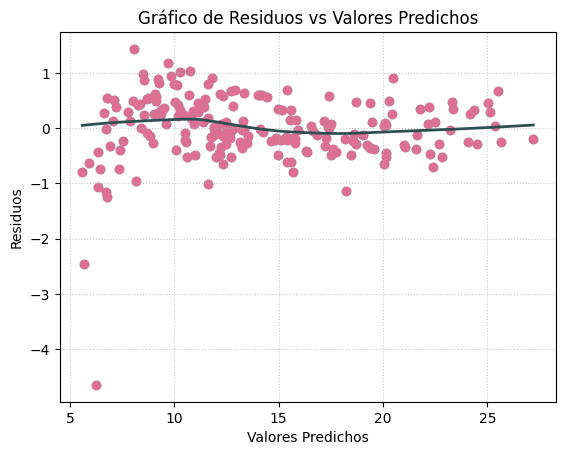

In [148]:
residuos = y - y_pred
lowess_line = lowess(residuos, y_pred, frac=0.7) 

plt.scatter(y_pred, residuos, alpha=0.6)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='darkslategrey', linewidth=2)

plt.scatter(y_pred, residuos, color = 'palevioletred')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs Valores Predichos')
plt.grid(linestyle=':', alpha=0.7)
plt.show()

In [149]:
comparacion_poly

,Modelo,R^2
0,Lineal,0.8972106381789522
1,Polinómico Grado 2,0.9865057435307856


Mejoró la linealidad entre factores y respuesta, y como se puede ver en la tabla comparativa, también el R2.

In [150]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_poly_df, y)
y_ridge_pred = ridge.predict(x_poly_df)
r2_ridge = r2_score(y, y_ridge_pred)
lasso = Lasso(alpha=0.1)
lasso.fit(x_poly_df, y)
y_lasso_pred = lasso.predict(x_poly_df)
r2_lasso = r2_score(y, y_lasso_pred)

comparacion = pd.DataFrame({
    "Modelo": ["Lineal","Polinómico Grado 2", "Ridge", "Lasso"],
    "R^2": [r2_lineal, r2_poly, r2_ridge, r2_lasso]
})
comparacion

,Modelo,R^2
0,Lineal,0.8972106381789522
1,Polinómico Grado 2,0.9865057435307856
2,Ridge,0.9865057434861318
3,Lasso,0.9864627566329087


No mejoró considerablemente.

Ahora se quitarán los outliers.

In [151]:
from scipy.stats import zscore

z_scores = np.abs(zscore(x))
df_sin_outliers = x[(z_scores < 3).all(axis=1)]
df_sin_outliers
model_sin_outliers = LinearRegression()
model_sin_outliers.fit(df_sin_outliers, y.loc[df_sin_outliers.index])
y_sin_outliers_pred = model_sin_outliers.predict(df_sin_outliers)
r2_sin_outliers = r2_score(y.loc[df_sin_outliers.index], y_sin_outliers_pred)
comparacion_sin_outliers = pd.DataFrame({
    "Modelo": ["Con outliers","Sin outliers"],
    "R^2": [r2_lineal, r2_sin_outliers]
})
comparacion_sin_outliers

,Modelo,R^2
0,Con outliers,0.8972106381789522
1,Sin outliers,0.8953917183024752


No mejoró.

Ahora se analizarán los p-values

In [152]:
x_plus_constant = sm.add_constant(x_poly_df)
model_sm = sm.OLS(y, x_plus_constant).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1543.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          1.72e-172
Time:                        17:29:55   Log-Likelihood:                -183.14
No. Observations:                 200   AIC:                             386.3
Df Residuals:                     190   BIC:                             419.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.0848      0.239     21.279      0.000       4.613       5.556
TV                  0.0517      0.002     22.997      0.000       0.047       0.056
radio               0.0211      0.013      1.675      0.096      -0.004       0.046
newspaper           0.0069      0.008      0.863      0.389      -0.009       0.023
TV^2               -0.0001   6.95e-06    -15.778      0.000      -0.000    -9.6e-05
TV radio            0.0011   3.81e-05     29.043      0.000       0.001       0.001
TV newspaper    -4.552e-05   2.38e-05     -1.915      0.057   -9.24e-05    1.37e-06
radio^2             0.0001      0.000      0.458      0.647      -0.000       0.001
radio newspaper  8.266e-05      0.000      0.486      0.628      -0.000       0.000
newspaper^2      1.191e-05   7.34e-05      0.162      0.871      -0.000       0.000
==============================================================================
Omnibus:                      145.912   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2613.928
Skew:                          -2.477   Prob(JB):                         0.00
Kurtosis:                      20.004   Cond. No.                     2.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Eliminando los p-values más altos

In [153]:
x_sin_caracteristicas = x_poly_df.drop(columns=['newspaper', 'radio^2', 'radio newspaper', 'newspaper^2'])
model_pvals = LinearRegression()
model_pvals.fit(x_sin_caracteristicas, y)
y_pvals_pred = model_pvals.predict(x_sin_caracteristicas)
r2_pvals = r2_score(y, y_pvals_pred)

comparacion_pvals = pd.DataFrame({
    "Modelo": ["Lineal", "Polinómico Grado 2", "Polinómico Grado 2 sin p-valores altos"],
    "R^2": [r2_lineal, r2_poly, r2_pvals]
})
comparacion_pvals

,Modelo,R^2
0,Lineal,0.8972106381789522
1,Polinómico Grado 2,0.9865057435307856
2,Polinómico Grado 2 sin p-valores altos,0.9859991218111042


No mejoró. El mejor es Polinómico grado 2.

# 4

In [154]:
ult_model = LinearRegression()
ult_model.fit(x_poly_df, y)
y_ult_pred = ult_model.predict(x_poly_df)
r2_ult = r2_score(y, y_ult_pred)
print(f"R^2 score para X modificado: {r2_ult}")

R^2 score para X modificado: 0.9865057435307856


In [155]:
ult_xgb = xgb.XGBRegressor(random_state=42)
ult_xgb.fit(x_poly_df, y)
y_ult_xgb_pred = ult_xgb.predict(x_poly_df)
r2_ult_xgb = r2_score(y, y_ult_xgb_pred)
print(f"R^2 score para X modificado con XGBoost: {r2_ult_xgb}")

R^2 score para X modificado con XGBoost: 0.9999999531898979


In [156]:
def objective_final(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    model.fit(x_poly_df, y)
    y_pred = model.predict(x_poly_df)
    r2 = r2_score(y, y_pred)
    return r2

study_final = optuna.create_study(direction='maximize')
study_final.optimize(objective_final, n_trials=50)
print("Best trial:")
trial_final = study_final.best_trial
print(f"  Value: {trial_final.value}")
print("  Params: ")
for key, value in trial_final.params.items():
    print(f"    {key}: {value}")    

[I 2025-12-04 17:29:55,454] A new study created in memory with name: no-name-a61fc319-d924-43aa-83dc-8698394af4c8
[I 2025-12-04 17:29:55,853] Trial 0 finished with value: 0.9999982468111254 and parameters: {'n_estimators': 464, 'max_depth': 4, 'learning_rate': 0.0940181594810775, 'subsample': 0.6283350835701855, 'colsample_bytree': 0.6295576492482289}. Best is trial 0 with value: 0.9999982468111254.
[I 2025-12-04 17:29:56,142] Trial 1 finished with value: 0.9999999889858624 and parameters: {'n_estimators': 382, 'max_depth': 5, 'learning_rate': 0.20312184871166372, 'subsample': 0.727667215151477, 'colsample_bytree': 0.8055344500091315}. Best is trial 1 with value: 0.9999999889858624.
[I 2025-12-04 17:29:56,502] Trial 2 finished with value: 0.9999999709004468 and parameters: {'n_estimators': 397, 'max_depth': 5, 'learning_rate': 0.11668385808890407, 'subsample': 0.9426017384996309, 'colsample_bytree': 0.8414866234359502}. Best is trial 1 with value: 0.9999999889858624.
[I 2025-12-04 17:2

Best trial:
  Value: 0.9999999933184832
  Params: 
    n_estimators: 389
    max_depth: 6
    learning_rate: 0.297715088502841
    subsample: 0.5027610706005095
    colsample_bytree: 0.969280179304823


In [157]:
pd.set_option("display.float_format", lambda x: f"{x:.16f}")
opt_params_final = trial_final.params
final_model = xgb.XGBRegressor(**opt_params_final, random_state=42)
final_model.fit(x_poly_df, y)
y_final_pred = final_model.predict(x_poly_df)
r2_final = r2_score(y, y_final_pred)
xgb_comparacion = pd.DataFrame({
    "Modelo": ["XGBoost Inicial", "XGBoost Hiperparámetros Óptimos", "XGBoost con X modificado", "XGBoost con X modificado e Hiperparámetros Óptimos"],
    "R^2": [r2, r2_optimized, r2_ult_xgb, r2_final]
})
xgb_comparacion

,Modelo,R^2
0,XGBoost Inicial,0.9999997795043769
1,XGBoost Hiperparámetros Óptimos,0.9999999894586263
2,XGBoost con X modificado,0.9999999531898979
3,XGBoost con X modificado e Hiperparámetros Ópt...,0.9999999933184832


In [158]:
todos_comparacion = pd.DataFrame({
    "Modelo": ["Lineal","Polinómico Grado 2", "Ridge", "Lasso", "Sin outliers", "XGBoost Inicial", "XGBoost Hiperparámetros Óptimos", "XGBoost con X modificado", "XGBoost con X modificado e Hiperparámetros Óptimos"],
    "R^2": [r2_lineal, r2_poly, r2_ridge, r2_lasso, r2_sin_outliers, r2, r2_optimized, r2_ult_xgb, r2_final]
})
todos_comparacion

,Modelo,R^2
0,Lineal,0.8972106381789522
1,Polinómico Grado 2,0.9865057435307856
2,Ridge,0.9865057434861318
3,Lasso,0.9864627566329087
4,Sin outliers,0.8953917183024752
5,XGBoost Inicial,0.9999997795043769
6,XGBoost Hiperparámetros Óptimos,0.9999999894586263
7,XGBoost con X modificado,0.9999999531898979
8,XGBoost con X modificado e Hiperparámetros Ópt...,0.9999999933184832


In [159]:
todos_comparacion['R^2'].max()
indice_mejor_modelo = todos_comparacion['R^2'].idxmax()
mejor_modelo = todos_comparacion.loc[indice_mejor_modelo]
mejor_modelo

Modelo    XGBoost con X modificado e Hiperparámetros Ópt...
R^2                                      0.9999999933184832
Name: 8, dtype: object

# Conclusiones

Los modelos sí mejoraron después de corregir los problemas detectados. La transformación polinomial fue el cambio que más impacto tuvo en el desempeño. Además, la optimización bayesiana contribuyó a mejorar significativamente los resultados. En conjunto, el mejor desempeño se obtuvo con el modelo XGBoost utilizando la versión modificada de X junto con los hiperparámetros óptimos.